# Load & Explore Data

In [1]:
import numpy as np
import pandas as pd
import nltk
import re

In [2]:
data = pd.read_csv("C:\\Users\\britt\\OneDrive\\Desktop\\Unstructured\\mtsamples.csv")

display(data.shape)
data.head()

(4999, 6)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [3]:
#Remove whitespace

data = data.assign(medical_specialty=lambda x: x.medical_specialty.str.strip())

In [4]:
#Subset to 3 specialty rows

data = data[data.medical_specialty.isin(["Cardiovascular / Pulmonary", "Neurology", "Orthopedic"])]

Imported all dependencies needed to start. Read in same mtsamples file from local drive. Needed to reduce again to 3 specified specialties - cardio, neuro, and ortho. Probably don't need to reduce columns this time and just define them as X and y when ready to model.

In [5]:
data.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
7,7,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 3,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram..."
9,9,Echocardiogram and Doppler,Cardiovascular / Pulmonary,2-D Echocardiogram - 4,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,..."
11,11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler..."


In [6]:
#Rerun shape/value counts to see how everything looks now

data.head()
display(data.shape)

(950, 6)

Shape method shows reduced rows to 950 with 6 columns. Extra spacing removed from medical specialties. Noting that all text is seen as objects right now and might need to change to string later on.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 950 entries, 3 to 4976
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         950 non-null    int64 
 1   description        950 non-null    object
 2   medical_specialty  950 non-null    object
 3   sample_name        950 non-null    object
 4   transcription      949 non-null    object
 5   keywords           752 non-null    object
dtypes: int64(1), object(5)
memory usage: 52.0+ KB


In [8]:
# Convert transcriptions from objects to strings

data["transcription"] = data["transcription"].astype(str)

# Text Pre-processing

In [9]:
# Remove stopwords and punctuation
# Change all characters to lowercase
# Tokenize words
# Normalize

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(data['transcription']))
len(norm_corpus)

950

Pre-processing removed symbols, punctuation, common English stopwords, and tokenized words. Then tokens in transcription column were vectorized with normalize_document. Functions did require objects to be converted to strings, so that was done in the previous step.

# Feature Engineering

In [10]:
# Extract TF-IDF Features

from sklearn.feature_extraction.text import CountVectorizer
# Remove extra stopwords that would be ubiquitous in medical docs, but add no context.
stop_words = stop_words + ['medical', 'doctor', 'health', 'test', 'right', 'left', 'medicine', 'hospital', 'ER', 'procedure', 'also']

cv = CountVectorizer(ngram_range=(1, 3,), min_df=10, max_df=0.8, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

C:\Users\britt\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['er'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(950, 5139)

The count vectorizer set ngrams up to 3. Trigrams chosen just to give more combination options to the text grouping. TF-IDF was selected as it would help identify rarer words, which is useful for this problem. Additional stopwords were added that would make sense to remove from transcripts. Now, there are 950 rows and 5,139 features. 

# K-Means

In [11]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 3
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(cv_matrix)
km

KMeans(max_iter=10000, n_clusters=3, n_init=50, random_state=42)

In [12]:
from collections import Counter

Counter(km.labels_)

Counter({1: 706, 2: 190, 0: 54})

Vectorized transcripts were fed into k-means model with a hyperparamter k searching for 3 centroids and measuring for 3 total clusters. Distribution is somewhat uneven. Adding new column to the dataframe.

In [13]:
data['kmeans_cluster'] = km.labels_

In [14]:
tran_clusters = (data[['medical_specialty', 'kmeans_cluster', 'transcription']]
                  .sort_values(by=['kmeans_cluster', 'transcription'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
tran_clusters = tran_clusters.copy(deep=True)

Created lists by cluster.

In [15]:
feature_names = cv.get_feature_names()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get transcriptions belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    transcriptions = tran_clusters[tran_clusters['kmeans_cluster'] == cluster_num]['medical_specialty'].values.tolist()
    print('CLUSTER #'+str(cluster_num))
    print('Key Features:', key_features)
    print('Transcriptions:', transcriptions)
    print('-'*80)

CLUSTER #0
Key Features: ['artery', 'coronary', 'catheter', 'coronary artery', 'pulmonary', 'femoral', 'stenosis', 'performed', 'proximal', 'vessel', 'descending', 'pressure', 'sheath', 'branch', 'ventricular']
Transcriptions: ['Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary']
--------------------------------------------------------------------------------
CLUSTER #1
Key Features: ['history', 'normal', 'pain', 'mg', 'time', 'well', 'without', 'mi

Cluster 0 shows that Cardio is clustered together quite a bit. Words like 'catheter,' 'coronary artery,' and 'stenosis' make it clear as to why. So Cardio basically stayed on its own and didn't overlap much with the other two specialities. Clusters 1 and 2 show that Neuro and Ortho overlap a lot. However, both clusters show words that should probably be removed with the stopwords function. Words like 'history,' 'note, and 'time' don't really help find broader patterns. 

# Visualize with t-sne

In [16]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


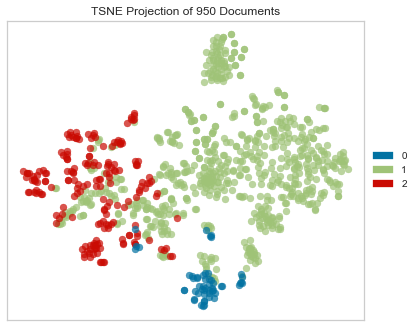

In [17]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(cv_matrix, km.labels_)
tsne.poof()

The t-sne 2D visualization shows that the clusters are different sizes. While there isn't a lot of overlap, there is still some, especially with clusters 1 and 2. Cluster 0 is really too small.

### Try Cosine Similarity

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_features = cosine_similarity(cv_matrix)
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(cosine_sim_features)
Counter(km.labels_)

Counter({2: 351, 1: 287, 0: 312})

In [19]:
data['kmeans_cluster'] = km.labels_

tran_clusters = (data[['medical_specialty', 'kmeans_cluster', 'transcription']]
                  .sort_values(by=['kmeans_cluster', 'transcription'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
tran_clusters = tran_clusters.copy(deep=True)

In [20]:
feature_names = cv.get_feature_names()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get transcriptions belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    transcriptions = tran_clusters[tran_clusters['kmeans_cluster'] == cluster_num]['medical_specialty'].values.tolist()
    print('CLUSTER #'+str(cluster_num))
    print('Key Features:', key_features)
    print('Transcriptions:', transcriptions)
    print('-'*80)

CLUSTER #0
Key Features: ['activity', '103', '250 mmhg foot', 'air entry', '76', '80', '600 mg', '16 mm', '106', '15 blade', 'age', 'agreed', '13', 'allergic', '10 ml']
Transcriptions: ['Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Orthopedic', 'Orthopedic', 'Orthopedic', 'Orthopedic', 'Orthopedic', 'Cardiovascular / Pulmonary', 'Orthopedic', 'Orthopedic', 'Neurology', 'Orthopedic', 'Cardiovascular / Pulmonary', 'Orthopedic', 'Orthopedic', 'Orthopedic', 'Orthopedic', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary', 'Cardiovascular / Pulmonary']
--------------------------------------------------------------------------------
CLUSTER #1
Key Features: ['34', '21', 'attachment', 'answered', '90', 'aspects', 'angle', '5mm', 'carpal', 'born', 'chamber', 'administration', '24', 'aphasia', 'anesthesia administered patient']
Transcriptions: ['Orthopedic', 'Orthopedic', 'Neurology', 'Neurology', 'Cardiovascular / Pulmonary', 'Neurology', 'Neurology', 'Cardiovascular / P

The key features in the clusters changed dramatically and the words seem to be more insightful. Cardio is clearly now a bit more prevelant throughout the clusters. Numbers have been introduced, which could reveal something interesting. New words like 'air entry,' 'catheter removed,' and 'chamber' seem to show that different specialties have some things in common like procedures. It might be a good idea to stem some of these words like 'catheter,' 'cath,' and 'catheterization.' However, they did all get grouped in the same cluster, so really it would just help to make more room for other words. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


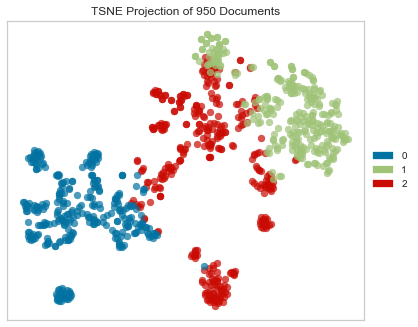

In [21]:
tsne = TSNEVisualizer()
tsne.fit(cosine_sim_features, km.labels_)
tsne.poof()

The new t-sne visual is much better. The clusters are now about equal in size and they have much less overlap. 